#  <center> Speech Emotion Recognition <center>

# Download Dataset

In [ ]:
!gdown "1ur4CrYKZT197pOCdZCSt-7DabXbcp-x_"

Downloading...
From: https://drive.google.com/uc?id=1ur4CrYKZT197pOCdZCSt-7DabXbcp-x_
To: /content/kaggle.json
100% 63.0/63.0 [00:00<00:00, 210kB/s]


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

100% 428M/429M [00:15<00:00, 29.7MB/s]
100% 429M/429M [00:15<00:00, 29.3MB/s]


In [ ]:
!unzip ravdess-emotional-speech-audio.zip -d /content/dataset

Archive:  ravdess-emotional-speech-audio.zip
  inflating: /content/dataset/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: /content/dataset/A

In [ ]:
#!rm -rf /content/*

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import sys
import shutil

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation


In [ ]:
base_source_directory = '/content/dataset/'
destination_directories = {
    'Depression': '/content/dataset/ravdes/Depression/',
    'NonDepression': '/content/dataset/ravdes/NonDepression/'
}

def copy_files_with_specific_number():
    count = 0  # Initialize a counter
    for i in range(1, 25):  # Loop from Actor_01 to Actor_24
        actor_folder = f"Actor_{str(i).zfill(2)}"  # Create actor folder string (e.g., Actor_01, Actor_02, ..., Actor_24)
        source_directory = os.path.join(base_source_directory, actor_folder)

        for category, base_destination_directory in destination_directories.items():
            destination_directory = os.path.join(base_destination_directory, actor_folder)

            # Create destination directory if it doesn't exist
            if not os.path.exists(destination_directory):
                os.makedirs(destination_directory)

            for filename in os.listdir(source_directory):
                if '-' in filename:
                    parts = filename.split('-')
                    if len(parts) >= 3:
                        number = parts[2][:2]
                        if (category == 'Depression' and number in ['04', '05', '06', '07']) or \
                           (category == 'NonDepression' and number in ['01', '02', '03', '08']):
                            source_path = os.path.join(source_directory, filename)
                            destination_path = os.path.join(destination_directory, filename)
                            shutil.copy(source_path, destination_path)
                            count += 1  # Increment the counter
    print(f"Total files moved: {count}")

copy_files_with_specific_number()

Total files moved: 1440


In [ ]:
records = []
for dirname, _, filenames in os.walk('/content/dataset/ravdes'):
    for filename in filenames:
        records.append([filename, os.path.join(dirname,filename)])

data = pd.DataFrame(records, columns=['filename','Path'])
data['actor'] = data['Path'].apply(lambda x: re.findall("\w+_\d+",x)[0])
data = data[data['actor']!="audio_speech_actors_01"]
data.reset_index(inplace=True,drop=True)
data['type'] = data['filename'].apply(lambda x: re.split("-\d+\.wav",x)[0])
data

filename  \
0     03-01-05-01-02-01-08.wav   
1     03-01-04-01-01-02-08.wav   
2     03-01-05-01-01-01-08.wav   
3     03-01-06-02-02-02-08.wav   
4     03-01-05-02-02-02-08.wav   
...                        ...   
1435  03-01-01-01-01-02-03.wav   
1436  03-01-08-02-01-01-03.wav   
1437  03-01-02-02-02-02-03.wav   
1438  03-01-08-01-01-01-03.wav   
1439  03-01-01-01-01-01-03.wav   

                                                   Path     actor  \
0     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
1     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
2     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
3     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
4     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
...                                                 ...       ...   
1435  /content/dataset/ravdes/NonDepression/Actor_03...  Actor_03   
1436  /content/dataset/ravdes/NonDepression/Actor_03...  Actor_03   
1437  /content/dataset/ravdes/NonDepression/Actor_03...  Actor_03   
1438  /content/dataset/ravdes/NonDepression/Actor_03...  Actor_03   
1439  /content/dataset/ravdes/NonDepression/Actor_03...  Actor_03   

                   type  
0     03-01-05-01-02-01  
1     03-01-04-01-01-02  
2     03-01-05-01-01-01  
3     03-01-06-02-02-02  
4     03-01-05-02-02-02  
...                 ...  
1435  03-01-01-01-01-02  
1436  03-01-08-02-01-01  
1437  03-01-02-02-02-02  
1438  03-01-08-01-01-01  
1439  03-01-01-01-01-01  

[1440 rows x 4 columns]

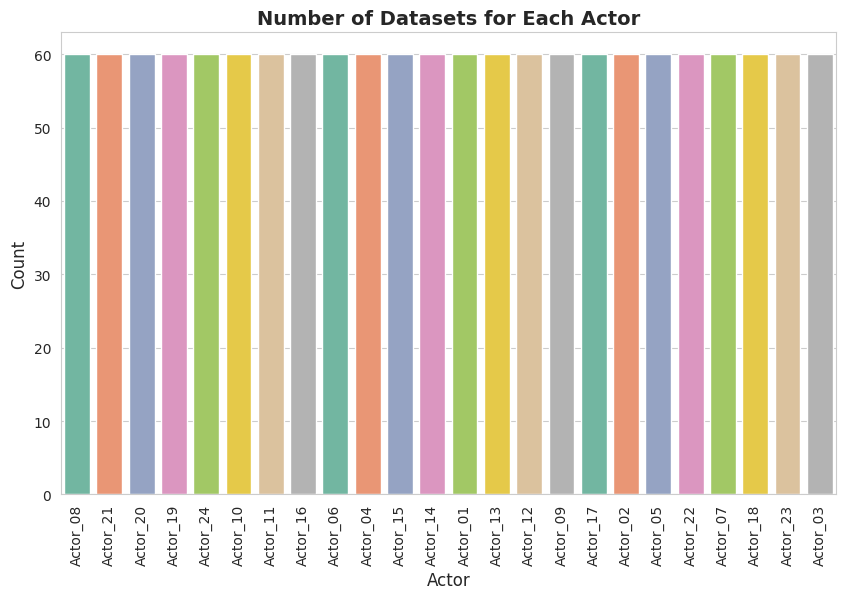

In [ ]:
# Create a countplot
plt.figure(figsize=(10,6))
sns.countplot(x='actor', data=data, palette="Set2", order = data['actor'].value_counts().index)

# Add title and labels
plt.title('Number of Datasets for Each Actor', fontsize=14, fontweight='bold')
plt.xlabel('Actor', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [ ]:
# Define a function to classify emotion
def classify_emotion(emotion):
    if emotion in ['01', '02', '03', '08']:
        return 'NonDepression'
    elif emotion in ['04', '05', '06', '07']:
        return 'Depression'

# Define a function to label gender
def label_gender(actor):
    if int(actor) % 2 == 0:
        return 'female'
    else:
        return 'male'
# Apply the functions to create new columns
data['Emotions'] = data['type'].apply(lambda x: classify_emotion(x.split('-')[2]))
data['gender'] = data['type'].apply(lambda x: label_gender(x.split('-')[5]))
data

filename  \
0     03-01-05-01-02-01-08.wav   
1     03-01-04-01-01-02-08.wav   
2     03-01-05-01-01-01-08.wav   
3     03-01-06-02-02-02-08.wav   
4     03-01-05-02-02-02-08.wav   
...                        ...   
1435  03-01-01-01-01-02-03.wav   
1436  03-01-08-02-01-01-03.wav   
1437  03-01-02-02-02-02-03.wav   
1438  03-01-08-01-01-01-03.wav   
1439  03-01-01-01-01-01-03.wav   

                                                   Path     actor  \
0     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
1     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
2     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
3     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
4     /content/dataset/ravdes/Depression/Actor_08/03...  Actor_08   
...                                                 ...       ...   
1435  /content/dataset/ravdes/NonDepression/Actor_03...  Actor_03   
1436  /content/dataset/ravdes/NonDepression/Actor_03...  Actor_03   
1437  /content/dataset/ravdes/NonDepression/Actor_03...  Actor_03   
1438  /content/dataset/ravdes/NonDepression/Actor_03...  Actor_03   
1439  /content/dataset/ravdes/NonDepression/Actor_03...  Actor_03   

                   type       Emotions  gender  
0     03-01-05-01-02-01     Depression    male  
1     03-01-04-01-01-02     Depression  female  
2     03-01-05-01-01-01     Depression    male  
3     03-01-06-02-02-02     Depression  female  
4     03-01-05-02-02-02     Depression  female  
...                 ...            ...     ...  
1435  03-01-01-01-01-02  NonDepression  female  
1436  03-01-08-02-01-01  NonDepression    male  
1437  03-01-02-02-02-02  NonDepression  female  
1438  03-01-08-01-01-01  NonDepression    male  
1439  03-01-01-01-01-01  NonDepression    male  

[1440 rows x 6 columns]

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

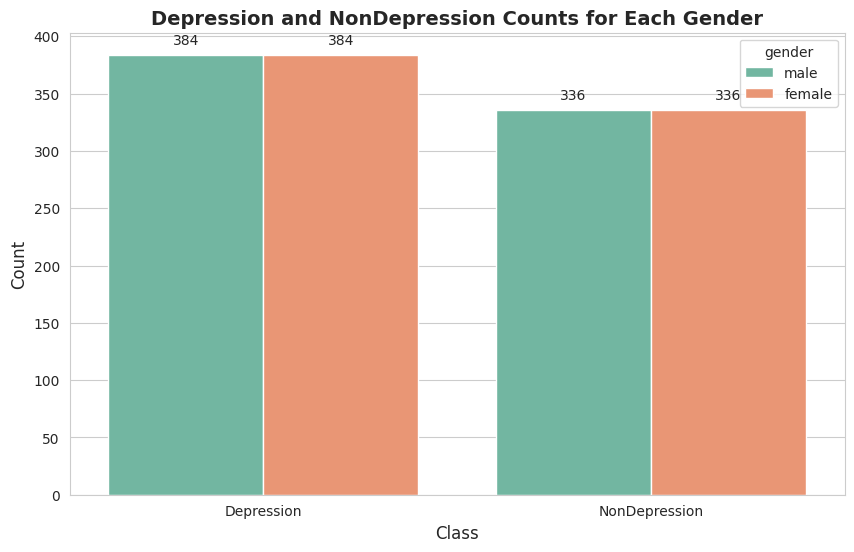

In [ ]:
# Create a countplot
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
palette = sns.color_palette("Set2")
ax = sns.countplot(x='class', hue='gender', data=data, palette=palette)

# Add title and labels
plt.title('Depression and NonDepression Counts for Each Gender', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count above each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# Show the plot
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

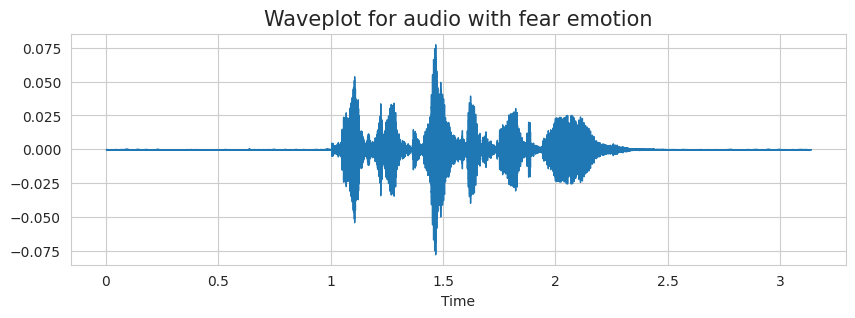

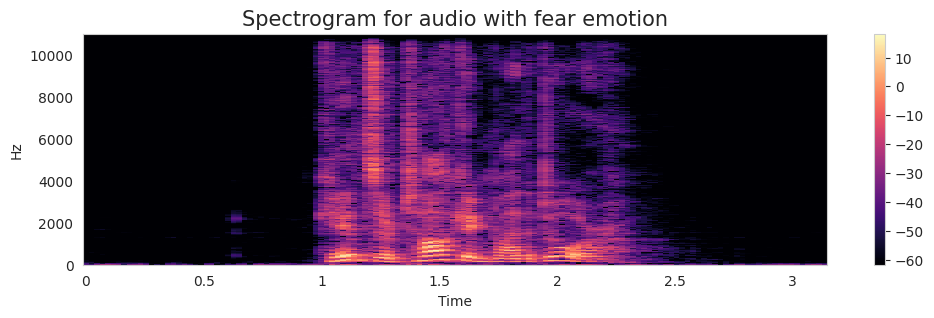

In [ ]:
emotion = 'fear'
path = "/content/dataset/ravdes/Depression/Actor_05/03-01-06-01-01-01-05.wav"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

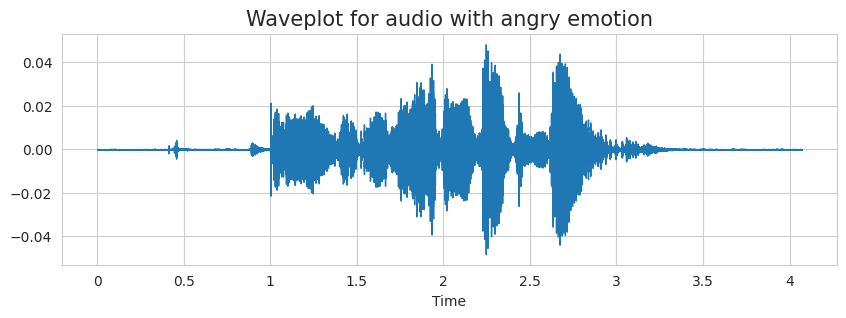

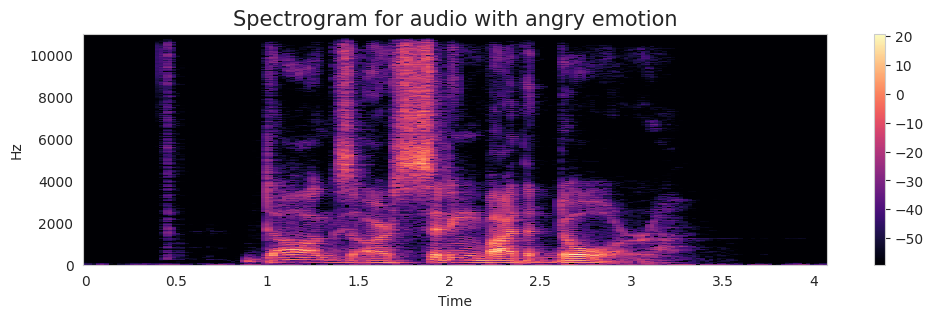

In [ ]:
emotion='angry'
path = '/content/dataset/ravdes/Depression/Actor_05/03-01-05-01-02-01-05.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

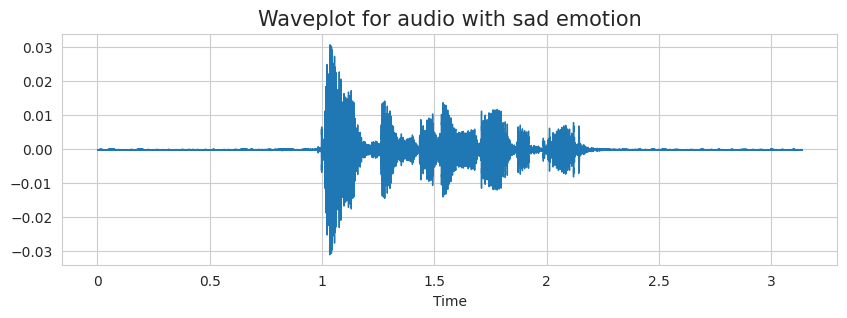

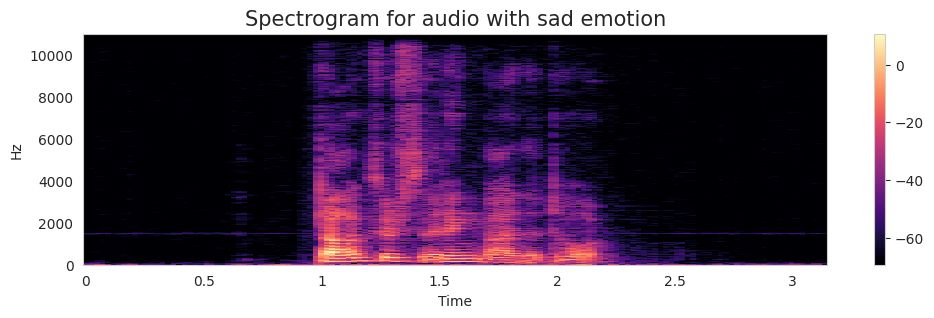

In [ ]:
emotion='sad'
path = '/content/dataset/ravdes/Depression/Actor_05/03-01-04-02-02-02-05.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

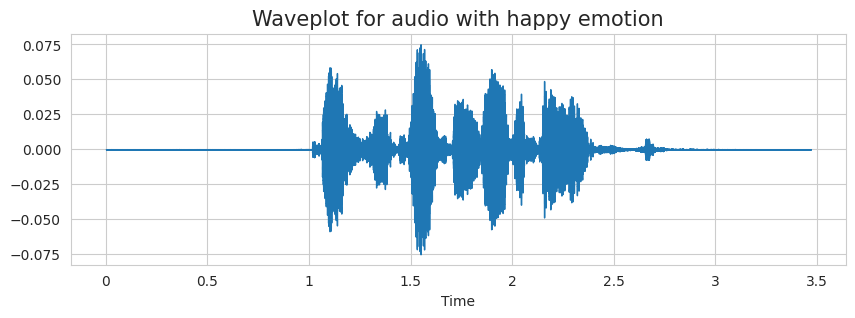

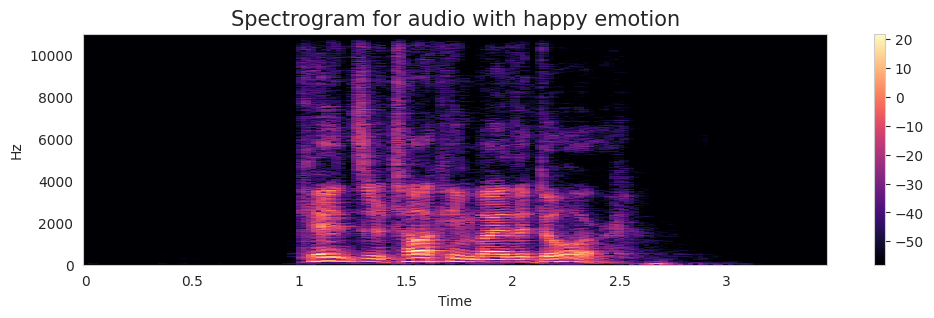

In [ ]:
emotion='happy'
path = '/content/dataset/ravdes/NonDepression/Actor_01/03-01-03-01-01-02-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [ ]:
depression_data = []
non_depression_data = []
directories = [
    '/content/dataset/ravdes/Depression',
    '/content/dataset/ravdes/NonDepression'
]

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, n_steps=0):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_steps)

for directory in directories:
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith('.wav'):
                filepath = os.path.join(root, filename)
                if 'depression' in filepath.lower():
                    depression_data.append(filepath)
                elif 'non depression' in filepath.lower():
                    non_depression_data.append(filepath)

#### 1. Simple Audio

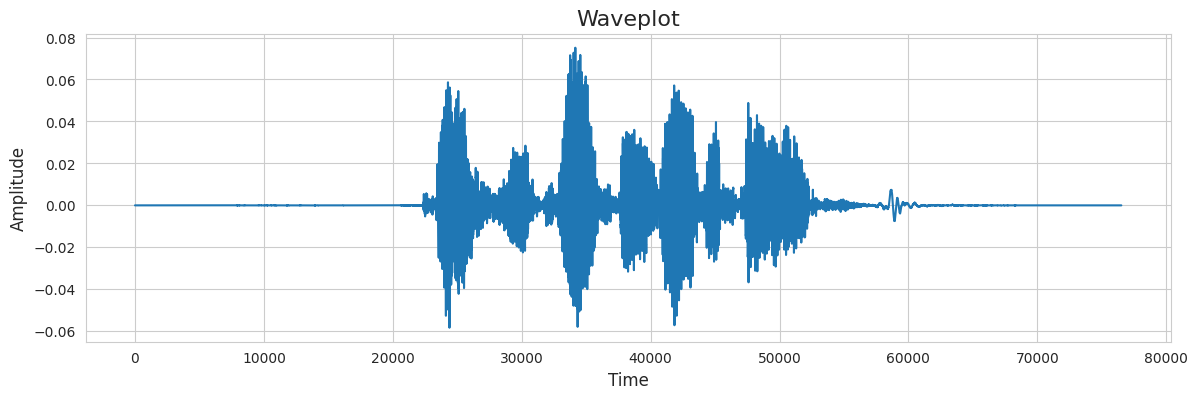

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Audio

pathnew = '/content/dataset/ravdes/NonDepression/Actor_05/03-01-01-01-02-01-05.wav'

plt.figure(figsize=(14, 4))
plt.plot(data)
plt.title('Waveplot', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()

Audio(pathnew)

#### 2. Noise Injection

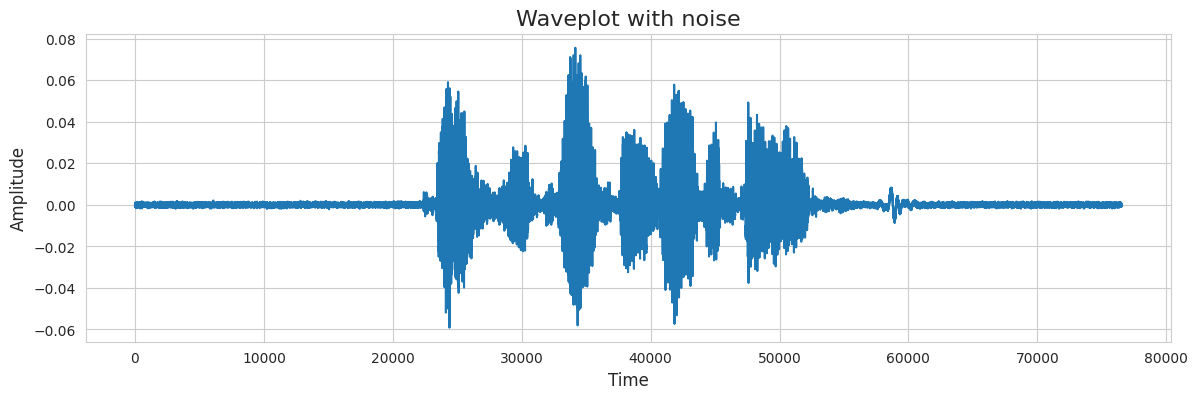

In [ ]:
x = noise(data)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveplot with noise', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()
data,sample_rate = librosa.load(pathnew)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

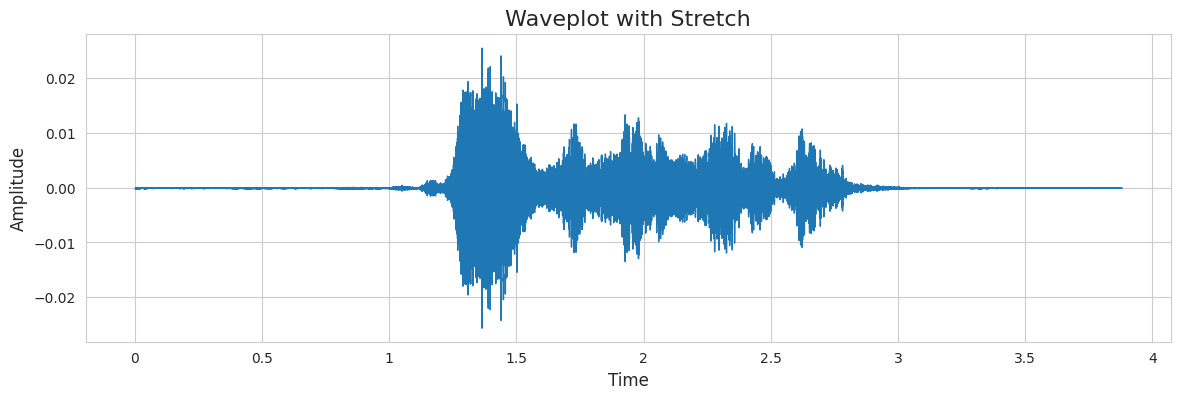

In [ ]:
x = stretch(data, rate=0.8)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Stretch', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()

Audio(x, rate=sample_rate)


#### 4. Shifting

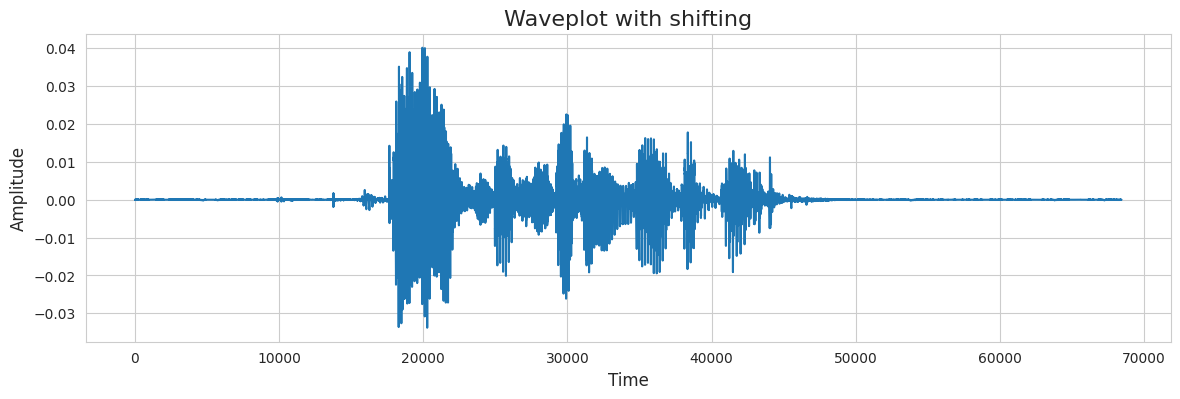

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveplot with shifting', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()
Audio(x, rate=sample_rate)


#### 5. Pitch

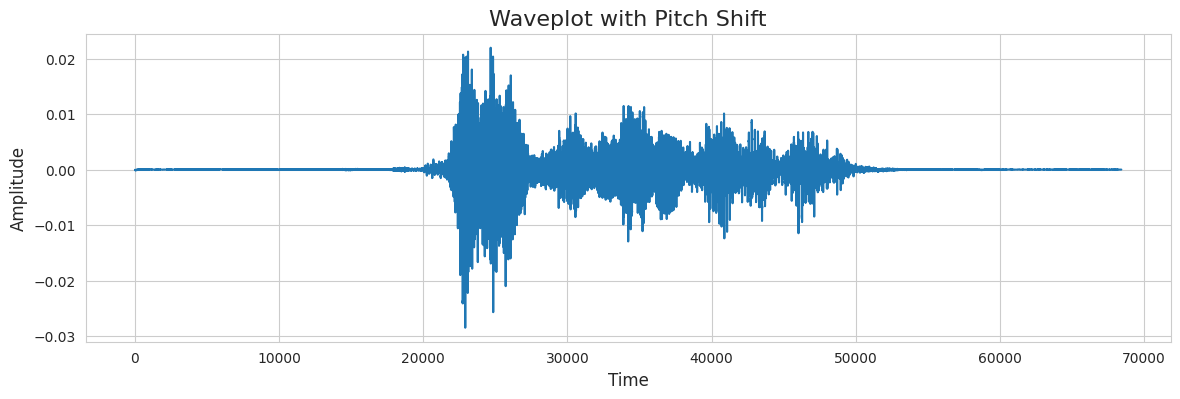

In [ ]:
# Pergeseran setengah nada (n_steps=1) sebagai contoh
x = pitch(data, n_steps=1)

plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveplot with Pitch Shift', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()

Audio(x, rate=sample_rate)


- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [ ]:
import numpy as np
import librosa

def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(data), sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonnetz))

    # Rolloff
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, rolloff))

    # Zero Crossing Rate Variance
    zcr_var = np.var(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr_var))

    return result

def get_features(pathbaru, sample_rate):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, _ = librosa.load(pathbaru, sr=sample_rate, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))  # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data.Path, data.Emotions):
    # Ubah path dengan menambahkan garis miring ("/") sebelum "Actor_"
    path = path.replace("Actor_", "/Actor_")
    feature = get_features(path, sample_rate)
    for ele in feature:
        X.append(ele)
        # appendin sxg emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=862
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=862
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=851
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=840
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=828
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=805
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: 

In [ ]:
len(X), len(Y), data.Path.shape

(4320, 4320, (1440,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features

0         1         2         3         4         5         6  \
0     0.143641  0.579482  0.595234  0.632813  0.636596  0.588011  0.611955   
1     0.315452  0.664103  0.692328  0.721792  0.709548  0.673108  0.635903   
2     0.116489  0.594997  0.632097  0.680815  0.594716  0.594738  0.626714   
3     0.151661  0.534762  0.535741  0.552786  0.564029  0.515566  0.566220   
4     0.268840  0.604115  0.644284  0.673015  0.638413  0.645664  0.649059   
...        ...       ...       ...       ...       ...       ...       ...   
4315  0.311560  0.746948  0.771719  0.760367  0.830013  0.778100  0.632469   
4316  0.152637  0.576537  0.628100  0.653131  0.666864  0.710446  0.591714   
4317  0.207361  0.666528  0.672453  0.684877  0.706324  0.734071  0.655705   
4318  0.299344  0.728732  0.729502  0.772370  0.771895  0.802787  0.713505   
4319  0.154008  0.661107  0.664406  0.702902  0.720582  0.741095  0.680604   

             7         8         9  ...        168       169       170  \
0     0.652872  0.690578  0.608819  ...  43.949342 -0.020145  0.041648   
1     0.666989  0.666793  0.633372  ...  13.990746  0.002165  0.001938   
2     0.701963  0.643953  0.582990  ...  44.734469  0.002980  0.007545   
3     0.681614  0.800305  0.718150  ...  44.485821 -0.021527  0.041244   
4     0.751971  0.784214  0.669923  ...  13.612204 -0.019894  0.057621   
...        ...       ...       ...  ...        ...       ...       ...   
4315  0.633411  0.667783  0.721633  ...  13.615452  0.007338 -0.021333   
4316  0.566019  0.547322  0.615138  ...  44.692300  0.032949 -0.055199   
4317  0.595859  0.627175  0.706308  ...  43.786942 -0.030866 -0.013546   
4318  0.648711  0.672531  0.748349  ...  13.633442 -0.017324 -0.022348   
4319  0.597251  0.603310  0.682677  ...  44.597154 -0.006577 -0.022657   

           171       172       173       174          175       176  \
0     0.009495 -0.058322  0.021805 -0.002302  5257.092285  0.014837   
1     0.020132 -0.034542  0.020828 -0.003393  8270.345052  0.037778   
2     0.009562 -0.032143  0.025778 -0.005398  5433.385417  0.016346   
3     0.068129 -0.091535  0.052318 -0.005775  4664.031982  0.013453   
4     0.086046 -0.051108  0.037950 -0.019521  7946.948242  0.032189   
...        ...       ...       ...       ...          ...       ...   
4315 -0.034809  0.038471  0.011359  0.001731  8285.697428  0.027732   
4316 -0.042399  0.042769  0.010126 -0.002270  5168.287760  0.007849   
4317  0.014678  0.018320 -0.002397 -0.012115  5019.030762  0.036889   
4318 -0.006264  0.032199 -0.000828 -0.023003  7931.496175  0.029129   
4319  0.031747  0.039395  0.017622 -0.020919  5084.627279  0.013980   

             labels  
0        Depression  
1        Depression  
2        Depression  
3        Depression  
4        Depression  
...             ...  
4315  NonDepression  
4316  NonDepression  
4317  NonDepression  
4318  NonDepression  
4319  NonDepression  

[4320 rows x 178 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical
import pandas as pd

# Load the data from the CSV file
# data_path = "/content/drive/MyDrive/pkm/data_ravdess33.csv"
# data = pd.read_csv(data_path)

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 177), (3240, 2), (1080, 177), (1080, 2))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 177), (3240, 2), (1080, 177), (1080, 2))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 177, 1), (3240, 2), (1080, 177, 1), (1080, 2))

## Modelling

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=2, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 177, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 89, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 89, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 45, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 23, 128)           0

In [ ]:
# # Change the last layer to have 1 unit and 'sigmoid' activation for binary classification
# model.add(Dense(units=2, activation='sigmoid'))

# # Update the loss function to 'binary_crossentropy'
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=60, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/60
51/51 [==============================] - 28s 501ms/step - loss: 0.6769 - accuracy: 0.5506 - val_loss: 0.6622 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 2/60
51/51 [==============================] - 27s 525ms/step - loss: 0.6623 - accuracy: 0.5762 - val_loss: 0.6550 - val_accuracy: 0.5852 - lr: 0.0010
Epoch 3/60
51/51 [==============================] - 23s 461ms/step - loss: 0.6570 - accuracy: 0.5762 - val_loss: 0.6518 - val_accuracy: 0.5824 - lr: 0.0010
Epoch 4/60
51/51 [==============================] - 28s 543ms/step - loss: 0.6512 - accuracy: 0.5731 - val_loss: 0.6529 - val_accuracy: 0.5685 - lr: 0.0010
Epoch 5/60
51/51 [==============================] - 24s 482ms/step - loss: 0.6391 - accuracy: 0.6077 - val_loss: 0.6399 - val_accuracy: 0.5972 - lr: 0.0010
Epoch 6/60
51/51 [==============================] - 23s 462ms/step - loss: 0.6245 - accuracy: 0.6253 - val_loss: 0.6461 - val_accuracy: 0.6157 - lr: 0.0010
Epoch 7/60
51/51 [==============================] - 25s 502ms/st

34/34 [==============================] - 2s 50ms/step - loss: 0.8720 - accuracy: 0.8250
Akurasi model pada data uji: 82.50%


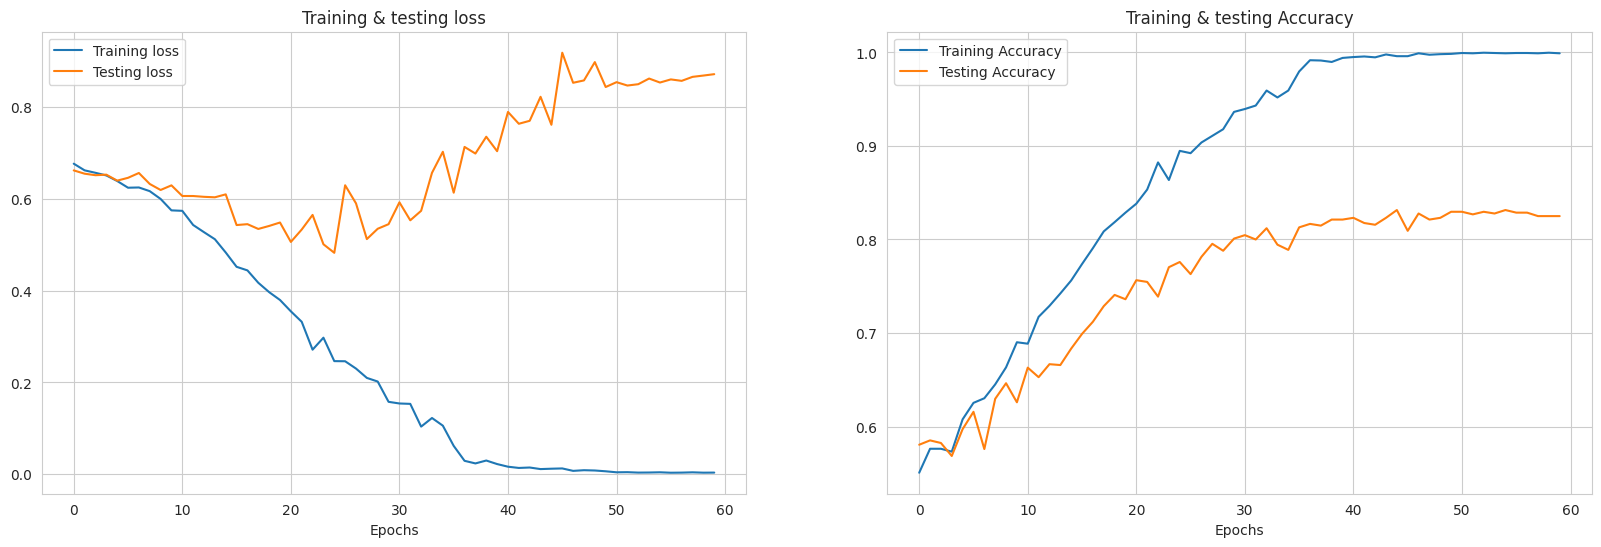

In [ ]:
# Menampilkan akurasi model pada data uji
accuracy = model.evaluate(x_test, y_test)[1] * 100
print("Akurasi model pada data uji: {:.2f}%".format(accuracy))

# Membuat grafik untuk pelatihan dan pengujian model
epochs = [i for i in range(60)]

# Menyiapkan subplot dan ukuran gambar
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

# Mengambil data pelatihan
train_acc = history.history['accuracy']
train_loss = history.history['loss']

# Mengambil data pengujian
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Grafik untuk kehilangan (loss)
ax[0].plot(epochs, train_loss, label='Training loss')
ax[0].plot(epochs, test_loss, label='Testing loss')
ax[0].set_title('Training & testing loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Grafik untuk akurasi
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

# Menampilkan grafik
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 3s 78ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head

<bound method NDFrame.head of      Predicted Labels  Actual Labels
0          Depression     Depression
1       NonDepression     Depression
2       NonDepression  NonDepression
3       NonDepression  NonDepression
4       NonDepression  NonDepression
...               ...            ...
1075       Depression     Depression
1076    NonDepression     Depression
1077    NonDepression  NonDepression
1078       Depression     Depression
1079    NonDepression  NonDepression

[1080 rows x 2 columns]>

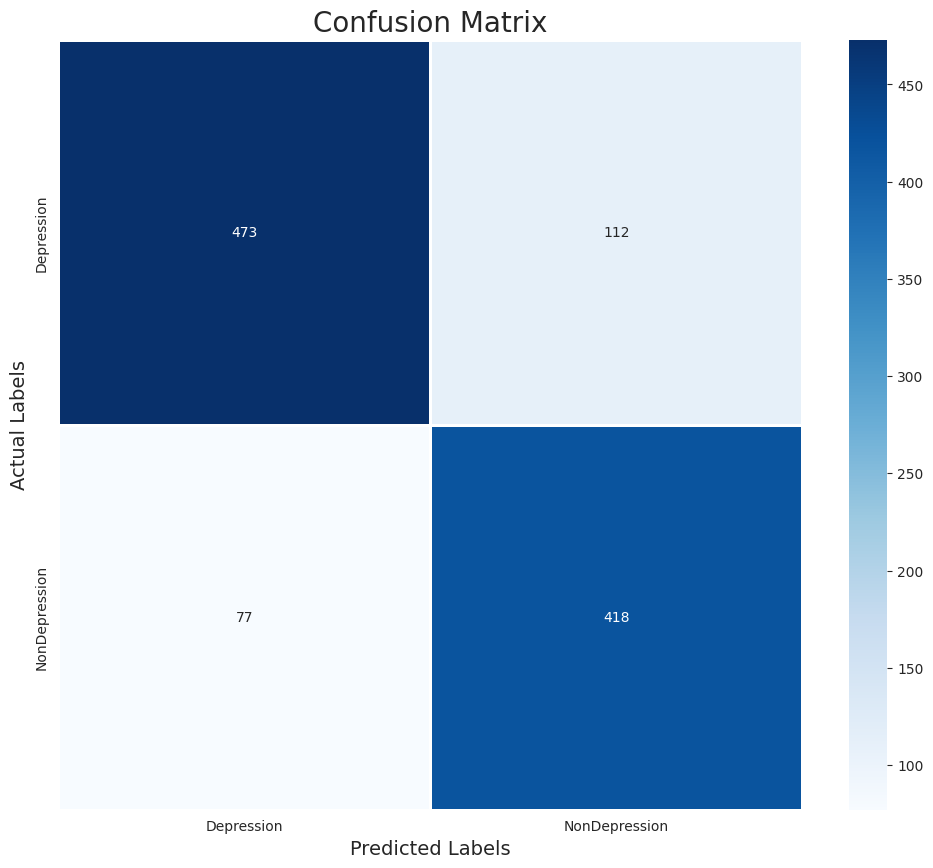

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

   Depression       0.86      0.81      0.83       585
NonDepression       0.79      0.84      0.82       495

     accuracy                           0.82      1080
    macro avg       0.82      0.83      0.82      1080
 weighted avg       0.83      0.82      0.83      1080



- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.